# Nonlinear Virus Spread

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate(); 

  Activating project at `~/.julia/dev/RxInfer/examples`


In this demo we consider a model for the spead of a virus (not COVID-19!) in a population. We are interested in estimating the reproduction rate from daily observations of the number of infected individuals. The reproduction rate indicates how many others are (on average) infected by one infected individual per time unit.

In [2]:
using RxInfer, Plots, Distributions

## Generate Data

We start by generating a toy dataset for a virus with a reproduction rate $a$. Here, $y$ represents the measured number of infected individuals, and $x$ a latent state.

In [3]:
# Generate toy dataset
T = 30
x_0_data = 0.6
a_data = 1.1

x_data = Vector{Float64}(undef, T)
y_data = Vector{Float64}(undef, T)

x_t_min_data = x_0_data
for t=1:T
    global x_data[t] = a_data*x_t_min_data
    global y_data[t] = ceil(x_data[t])
    global x_t_min_data = x_data[t]
end    
;

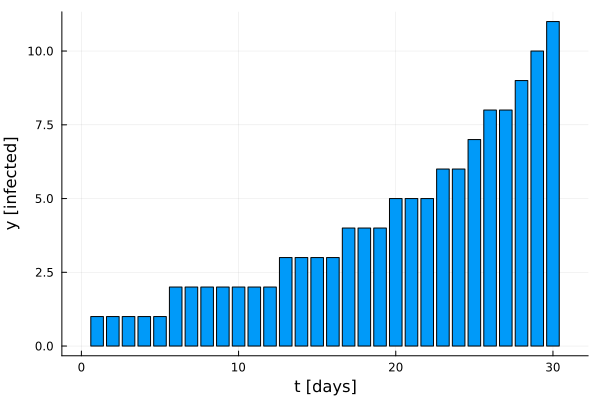

In [4]:
# Inspect data
bar(1:T, y_data, xlabel = "t [days]", ylabel = "y [infected]", label = false)

## Model specification

We define a state-space model, where we specify the state transition by a `g` function. 

In [5]:
g(x_t_min, a) = a * x_t_min

g (generic function with 1 method)

In [6]:
@model function virus_spread(n)
    x = randomvar(n)
    y = datavar(Float64, n)

    a ~ NormalMeanVariance(0.0, 100.0)
    x_0 ~ NormalMeanVariance(1.0, 10.0)

    x_prev = x_0
    for i in 1:n
        x[i] ~ g(x_prev, a)
        y[i] ~ NormalMeanVariance(x[i], 0.1)
        x_prev = x[i]
    end

end

In [7]:
meta = @meta begin 
    # `meta` specifies the approximation method, which will be used 
    # to approximate the nonlinearity
    g() -> Linearization()
end

Meta specification:
  g() -> Linearization()
Options:
  warn = true

In [8]:
result = inference(
    model = virus_spread(length(y_data)), 
    data = (y = y_data,),
    meta = meta,
    options = (limit_stack_depth = 100, ),
    returnvars = KeepLast(), 
    initmessages = (a = NormalMeanVariance(0.0, 10.0), ), 
)

Inference results:
  Posteriors       | available for (a, x_0, x)


In [9]:
m_x_t, v_x_t = mean.(result.posteriors[:x]), cov.(result.posteriors[:x]);
m_a, v_a = mean.(result.posteriors[:a]), cov.(result.posteriors[:a]);

## Inference results

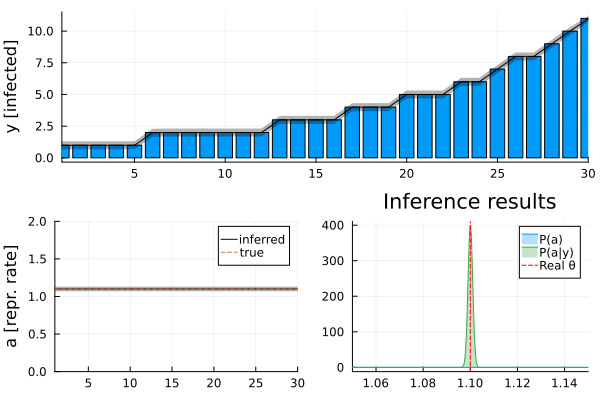

In [10]:
p1 = bar(1:T, y_data, label=false)
p1 = plot!(p1, 1:T, m_x_t, color=:black, ribbon=sqrt.(v_x_t), fillalpha=0.3, xlim=(1,T), ylabel="y [infected]", label=false)
p2 = plot(1:T, m_a*ones(T,), color=:black, ribbon=sqrt.(v_a)*ones(T,), fillalpha=0.3, xlim=(1,T), ylabel="a [repr. rate]", label="inferred")
p2 = plot!(p2, 1:T, a_data*ones(T), linestyle=:dash, label="true ", ylim = (0, 2))

rθ = range(1.05, 1.15, length = 1000)

p3 = plot(title = "Inference results", xlim = (1.05, 1.15))

p3 = plot!(p3, rθ, (x) -> pdf(Normal(0.0, 100.0), x), fillalpha=0.3, fillrange = 0, label="P(a)", c=1,)
p3 = plot!(p3, rθ, (x) -> pdf(Normal(mean(result.posteriors[:a]), var(result.posteriors[:a])), x), fillalpha=0.3, fillrange = 0, label="P(a|y)", c=3)
p3 = vline!(p3, [ a_data ], label="Real θ", linestyle=:dash, color = :red)

plot(p1, p2, p3,  layout = @layout([a; b c]))

As we can see the inference results match hidden states with high precision, as well as for the `a` parameter.